
# Multiplicative Free Convolution

## Goals of this script: 
- I.   Monte-Carlo for Multiplicative Free Convolutions
- II.  Inverting explicit S-transforms
- III. Application to FreeNN


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# I. Monte-Carlo for some explicit multiplicative free convolutions.

Recall that the Marchenko-Pastur law is the universal limit for singular values of Gaussian matrices. Following Marchenko and Pastur (1967)
$$ \frac{1}{2 \pi} \frac{\sqrt{(x-l)(r-x)}}{x} dx ,$$
where 
$$r = (1+\sqrt{c})^2$$
$$l = (1-\sqrt{c})^2$$
and $c$ being the scale parameter.

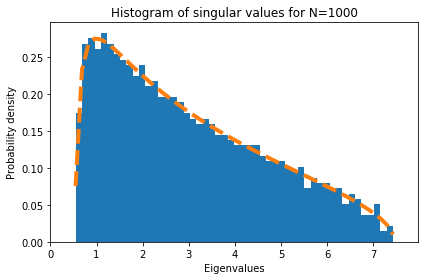

In [2]:
# One MP

N=1000
num_bins=50

c = 3 # MP scale parameter
r = (1+np.sqrt(c))**2 #Right end
l = (1-np.sqrt(c))**2 #Left end

G = np.random.normal( size=(N,c*N) )
W = G.dot( G.transpose() )
W = W/N
diag, U = np.linalg.eig(W)

# Histogram of singular values
fig, ax = plt.subplots()
n, bins, patches = ax.hist(diag, num_bins, density=True)
y = np.sqrt( (r-bins)*(bins-l) )/(2*np.pi*bins)
ax.plot(bins, y, '--', linewidth=4)
ax.set_xlabel('Eigenvalues')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of singular values for N={}'.format(N))
fig.tight_layout()
plt.xlim(0,r+0.5)
plt.show()

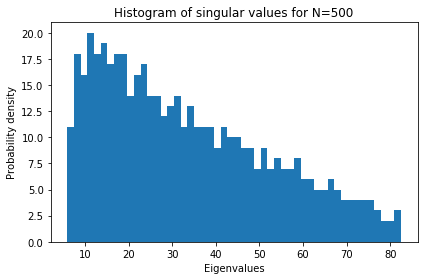

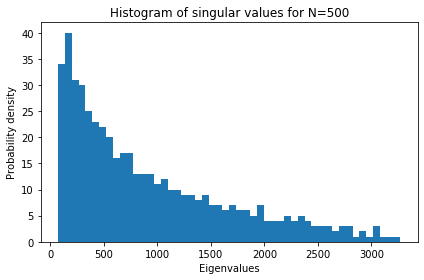

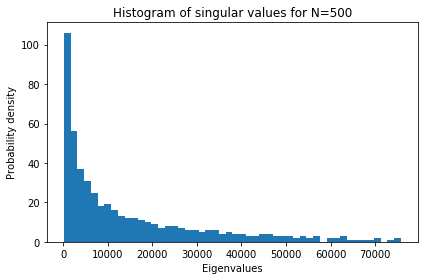

In [3]:
# Multiple ones
scale_params = [3, 1, 0.5]

N=500
num_bins=50

M = np.identity(N)
for c in scale_params:
    p, q = M.shape
    qq = int(c*q)
    G = np.random.normal( size=(q,qq) )/np.sqrt(np.sqrt(q+qq))
    M = M.dot( G )
    W = M.dot( M.transpose() )
    diag, U = np.linalg.eig(W)

    # Histogram of singular values
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(diag, num_bins)
    #y = np.sqrt( (r-bins)*(bins-l) )/(2*np.pi*bins)
    #ax.plot(bins)
    ax.set_xlabel('Eigenvalues')
    ax.set_ylabel('Probability density')
    ax.set_title(r'Histogram of singular values for N={}'.format(N))
    fig.tight_layout()
    plt.show()

# II. Inverting explicit S-transforms
Here we consider the $S$-transforms of Marchenko-Pastur distributions, which are of the form:
$$ S_{W_l}(z) = \frac{1}{\sigma_l} \frac{1}{1+\lambda_l z} \ ,$$
where the $\lambda_i$ are the scale pameters and $\sigma_l^2$ are the variances. For simplicity, we assume for now $\sigma_l^2=1$.

## 1. Basic definitions

In [115]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Array of \lambda_l's
scale_params = [3, 1, 0.5]
# Array of \Lambda_l / \lambda_l used for scaling z (Check error in paper!)
w_scaling    = np.cumprod(scale_params)/scale_params

# Compute coefficients of M_inverse (numerator and denominator)
# Conventions:
#   - Coefficients are numpy arrays
#   - Highest degree comes first
#
# Of numerator of M_inverse
roots         = np.append(-1, -1/w_scaling)
leading_coeff = np.prod(w_scaling)
coeff_num     = np.poly( roots ) * leading_coeff
# Of denominator of M_inverse = w
coeff_den     = np.array( [1, 0] )

# Derivatives
coeff_num1    = np.polyder(coeff_num)
coeff_num2    = np.polyder(coeff_num1)
coeff_den1    = np.polyder(coeff_den)
coeff_den2    = np.polyder(coeff_den1)

# Maximal degree
max_degree = max(len(coeff_num1), len(coeff_num2)) - 1

# Test
print(coeff_num)
print(coeff_den)
print( np.polyval(coeff_num, 0) )
print( np.polyval(coeff_den, 0) )

[ 9. 24. 22.  8.  1.]
[1 0]
1.0
0


In [187]:
# Pascal triangle
# Convention is that column is image of X^i
# via P(X) \mapsto P(X+1)
def pascal(n):
    mat       = np.identity(n, dtype=int)
    mat[:, 0] = 1
    for i in range(2,n):
        mat[i, 1:-1] = mat[i-1, 0:-2] + mat[i-1, 1:-1]
    # Satisfy indexing conventions
    mat = np.flip(mat, axis=0)
    mat = mat.transpose()
    mat = np.flip(mat, axis=0)
    #
    return mat

# Test
print("Pascal triangle: \n", pascal(8))
pascal_triangle = pascal(10)

Pascal triangle: 
 [[ 1  0  0  0  0  0  0  0]
 [ 7  1  0  0  0  0  0  0]
 [21  6  1  0  0  0  0  0]
 [35 15  5  1  0  0  0  0]
 [35 20 10  4  1  0  0  0]
 [21 15 10  6  3  1  0  0]
 [ 7  6  5  4  3  2  1  0]
 [ 1  1  1  1  1  1  1  1]]


In [190]:
pascal_triangle = pascal( max_degree + 1)

# Test: Taylor expansion of X^n at 1:
print( "Max degree: ", max_degree )
p    = np.zeros( (max_degree+1, 1), dtype=float)
p[0] = 1.0
print( pascal_triangle.dot( p ) )

Max degree:  3
[[1.]
 [3.]
 [3.]
 [1.]]


In [196]:
# If | P  (X) = \sum c_i X^i = \sum d_i (X-a)^i
#    | P_a(X) = \sum d_i X^i
# Computes P_a = Taylor expansion of P at a
def taylor_expand(p, a, pascal_triangle=None):
    #
    degree = len(p)-1
    if pascal_triangle is None:
        pascal_triangle = pascal(degree+1)
    diag = np.diag( a**np.array(range(0, degree+1)) )
    weighted_pascal = diag.dot( pascal_triangle )
    print(weighted_pascal)
    print(p)
    return weighted_pascal.dot(p)

# P(x) = (X-1)^3
p = np.array([1,-3, 3, -1])
#p = np.array([1, 0, 0, 0])
print(p)
print("Value of p(1): ", np.polyval(p, 1)    )
print("P at 1       : ", taylor_expand(p, 2) )

[ 1 -3  3 -1]
Value of p(1):  0
[[ 1  0  0  0]
 [ 6  2  0  0]
 [12  8  4  0]
 [ 8  8  8  8]]
[ 1 -3  3 -1]
P at 1       :  [1 0 0 0]


## 2. Implementation of Newton-Raphson

Important formulae
$$ m = zg - 1$$
$$ M^{\langle -1 \rangle}(z) g - 1 = z $$

In [133]:
def G(z):
    return (1+M(z))/z

def M_inverse(w):
    return np.polyval(coeff_num,w)/np.polyval(coeff_den,w)

In [134]:
# Classes wrapping functions for NR scheme using Kantorovich theorem for convergence

# Use case: 
# - Need that away from axis f(z, w=0 ) \approx 0
# - No exact proxy is available but good control on attraction basins
# - Poor bound on second derivative
class Kantorovich_Wrapper_1:
    
    def f(self, w, z):
        return np.polyval(coeff_num,w)/z - np.polyval(coeff_den,w)

    def f_prime(self, w, z):
        return np.polyval(coeff_num1,w)/z - np.polyval(coeff_den1,w)

    def f_second_bound(self, w, z, ball_max_y):
        return -2/(ball_max_y**2)


In [135]:
DEFAULT_PRECISION = 1e-8

# Computes the moment generating function M
# Uses a Newton-Raphson iteration for inverting from M^{(-1)}
# WARNING: Guess is not necessarily in basin of attraction, leading to failure
def compute_M_NR( z, function_wrapper, guess=None, error=None):
    if guess is None:
        w = 0
    else:
        w = guess
    #
    if error is None:
        error = DEFAULT_PRECISION
    #
    while True:
        value = function_wrapper.f(w, z)
        if ( abs(value) < error ):
            break
        grad = function_wrapper.f_prime(w, z)
        if ( abs(grad) < error ):
            print("Gradient too small!!")
            print("value: ", value)
            print("grad: ", grad)
            return None
            break
        #Newton-Raphson iteration
        w = w - value/grad
    #
    #print( "Newton-Raphson: ", value, grad)
    return w;

# Test for a value in basin of attraction
j = complex(0,1)
z = 1+ j*3
print("z: ", z)
fwrapper = Kantorovich_Wrapper_1()
w = compute_M_NR( z, function_wrapper=fwrapper )
print("M(z)         = ", w )
print("M_inverse(w) = ", M_inverse(w)   )
print("Error        = ", abs(z-M_inverse(w)) )

z:  (1+3j)
M(z)         =  (-0.10373103867493708-0.1057064855193843j)
M_inverse(w) =  (1.000000000000335+2.99999999999909j)
Error        =  9.696686880155501e-13


In [141]:
def is_in_basin_ZM(z, m, function_wrapper, debug=False):
    value      = function_wrapper.f(m, z)
    derivative = function_wrapper.f_prime(m, z)
    # Compute w value after one step
    step  = -value / derivative
    new_m = m + step
    if debug:
        print("")
        print("Call is_in_basin for z=",z)
        print("value:     ", value)
        print("derivative:", derivative)
        print("m:    ", m)
        print("new_m:", new_m)
        print("Im(m + h_0): ", new_m.imag)
    # Check if new_w in domain
    if new_m.imag >= 0:
       return False
    # Check if NR ball is in domain
    ball_max_y = new_m.imag + abs(step.imag)
    if debug:
        print("Im(m + h_0) + |Im(h_0)|: ", ball_max_y)
    #if ball_max_y >= 0:
    #    return False
    # Compute bound on second derivative
    bound_f_2 = function_wrapper.f_second_bound(w, z, ball_max_y)
    criterion = abs(step/derivative)*bound_f_2
    if debug:
        print("criterion: ", criterion)
    return criterion < 0.5

def is_in_basin_ZG(z, w, function_wrapper, debug=False):
    return is_in_basin_ZM(z, z*w-1, function_wrapper, debug)

fwrapper = Kantorovich_Wrapper_1()
z = complex(1,3)
print( is_in_basin_ZG(z, 1/z, function_wrapper = fwrapper, debug=True ) )
z = complex(1,1000)
print( is_in_basin_ZG(z, 1/z, function_wrapper = fwrapper, debug=True ) )


Call is_in_basin for z= (1+3j)
value:      (0.10000000000000002-0.2999999999999997j)
derivative: (-0.2000000000000005-2.3999999999999986j)
m:     (-1.1102230246251565e-16+0j)
new_m: (-0.12068965517241385-0.05172413793103455j)
Im(m + h_0):  -0.05172413793103455
Im(m + h_0) + |Im(h_0)|:  0.0
criterion:  -inf
True

Call is_in_basin for z= (1+1000j)
value:      (9.99999000001e-07-0.000999999000001j)
derivative: (-0.999992000008-0.007999992000008j)
m:     0j
new_m: (-6.999657016806176e-06-0.0009999510024008825j)
Im(m + h_0):  -0.0009999510024008825
Im(m + h_0) + |Im(h_0)|:  0.0
criterion:  -inf
True


/home/rchhaibi/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


In [148]:
# Computes the Stieljes transform G
# Uses a Newton-Raphson iteration for inverting and finding the w = M(z) such that:
# w = z G(z) - 1
# Guess is not necessarily in basin of attraction
def compute_G_NR( z, function_wrapper, guess=None, error=None):
    if guess is None:
        w = 1/z
    else:
        w = guess
    #
    if error is None:
        error = 1e-8
    #
    w = compute_M_NR( z, function_wrapper, guess=(z*guess-1), error=error)
    return (w+1)/z
    
def reset_counters():
    global call_counter_failed_basin
    global call_counter_NR
    call_counter_failed_basin = 0
    call_counter_NR    = 0
    
def compute_G_adaptative( z_objective, proxy=None, debug=False):
    global call_counter_failed_basin
    global call_counter_NR
    j       = complex(0,1)
    #
    # If no proxy is available, find high enough z in basin of attraction and compute associated w
    # This search uses a doubling strategy
    if proxy is None: 
        fwrapper = Kantorovich_Wrapper_1()
        z = z_objective
        g = 1/z
        while not is_in_basin_ZG(z, g, function_wrapper = fwrapper ):
            call_counter_failed_basin += 1
            z = z + j*z.imag
            g = 1/z
        g = compute_G_NR(z, function_wrapper = fwrapper, guess=g)
        if debug:
            print("Valid z: ", z)
            print("Guess g: ", 1/z)
            print("G(t,z) = ", g )
    else:
        z, g = proxy
        # Useless unless we use higher points for proxy
        # assert(z.real==z_objective.real)
        # assert(z.imag >z_objective.imag)
    if debug:
        print("Proxy (z,g): ", z, g)
    #
    # Starts heading towards the objective z
    while abs(z- z_objective)>0:
        fwrapper = Kantorovich_Wrapper_1()
        dz = z_objective-z
        while not is_in_basin(z+dz, z*g-1, function_wrapper=fwrapper):
            call_counter_failed_basin += 1
            dz = 0.5*dz
        z = z+dz
        g = compute_G_NR(z, function_wrapper=fwrapper, guess=g)
        call_counter_NR += 1
        if debug:
            print("Valid z: ", z)
            print("G(t,z) = ", g )
    # end while
    return g

j       = complex(0,1)
t       = 1
debug   = False
z_array = 1+ j*np.array([ 4, 1, 0.1, 0.01, 1e-3, 1e-5, 1e-8, 1e-10])
proxy   = None
for z in z_array:
    print("z: ", z)
    reset_counters()
    g = compute_G_adaptative( z, proxy=proxy)
    proxy = (z, g)
    print("G(z)  = ", g )
    z_check = M_inverse(z*g-1)
    print("M_inv = ", z_check )
    print("Error = ", abs(z_check-z) )
    print("Number of calls to NR: ", call_counter_NR)
    print("Number of calls to attraction basin test: ", call_counter_failed_basin)
    print("")


z:  (1+4j)
G(z)  =  (0.03074053410182172-0.2207840684976811j)
M_inv =  (1.0000000194198169+3.9999997958571174j)
Error =  2.0506449181327566e-07
Number of calls to NR:  0
Number of calls to attraction basin test:  0

z:  (1+1j)
G(z)  =  (0.5198762594674132-0.2519632965142691j)
M_inv =  (1.000000010926154+0.9999999741067358j)
Error =  2.8104127307763494e-08
Number of calls to NR:  1
Number of calls to attraction basin test:  0

z:  (1+0.1j)


/home/rchhaibi/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


KeyboardInterrupt: 

## 3.Computation of the measure (multiple passes)

In [ ]:
#Imports for 3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


#N: Space mesh
N=100
a=-2
b=10

#Init
time_grid  = [ T*(k/M)*(k/M) for k in range(M)]
space_grid = np.linspace(a, b, N)
dx = (b-a)/N

#Multiple passes for the number of iterations
#imaginary_parts = [2, 1.0, 0.5, 0.3, 0.1, 0.005, 0.001]
#imaginary_parts = [4.0, 1.0, 0.5, 0.1]
#imaginary_parts = [1.0, 0.1, 0.01, 0.001]
imaginary_parts = [1.0]
densities       = []
hilbert_transf  = []
pass_counter    = 0
iter_count      = [ [] for i in space_grid ]
errors1         = [ [] for i in space_grid ]
errors2         = [ [] for i in space_grid ]
choices         = [ [] for i in space_grid ]

j       = complex(0,1)
fig = plt.figure( figsize = (12,7) )
ax = fig.add_subplot( 111 )
y_proxy = None
guess   = None
G       = np.array( space_grid + complex(0,1) )
for y in imaginary_parts:
    start = time.time()
    reset_counters()
    # Compute
    z = np.array( space_grid + y*complex(0,1) )
    for i in range(N):
        if y_proxy is None:
            G[i] = compute_G_adaptative(z[i], proxy=None)
        else:
            guess = (z[i].real+j*y_proxy, G[i])
            G[i] = compute_G_adaptative(z[i], proxy=guess)
    # Statistics
    pass_counter += 1
    timing        = time.time() - start
    print ('Pass [{}/{}], Duration: {:.1f} ms' 
           .format(pass_counter, len(imaginary_parts), 1000*timing))
    print("Number of calls to NR: ", call_counter_NR)
    print("Number of calls to attraction basin test: ", call_counter_failed_basin)
    print("")
    # Plot
    ax.plot(space_grid, -np.imag(G)/np.pi, '--', label="y=%.3f"%y)
    ax.set(xlabel='Space (x)', ylabel='Value',
           title='Density')
    ax.grid()
    #
    y_proxy = y
plt.ylim(0,0.2)
plt.legend()
plt.show()
